In [11]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from itertools import islice
import random
from pathlib import Path
import pandas as pd
import os
# import matplotlib.pyplot as plt
from glob import glob
from hashlib import sha1
import multiprocessing

In [2]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from estimator import SwitchTransformerEstimator
from pytorch_lightning.loggers import CSVLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, DeviceStatsMonitor, EarlyStopping

2023-11-15 00:31:10.931592: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-15 00:31:10.975376: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
dataset = get_dataset("electricity")

In [4]:
seed = 0
experiment_name = "switch"
fulldir = experiment_name + "/" + str(seed)
os.makedirs(fulldir, exist_ok=True)


# Code to retrieve the version with the highest #epoch stored and restore it incl directory and its checkpoint
lightning_version_to_use, ckpt_path = None, None
max_epoch = -1
if "switch" in os.listdir(fulldir):
    ckpts = glob(fulldir+ sha1(fulldir.encode("utf-8")).hexdigest()[:8] + "/checkpoints/*.ckpt")
    if len(ckpts): ckpt_path = ckpts[0]
elif "lightning_logs" in os.listdir(fulldir):
    for lightning_version in os.listdir(fulldir+"/lightning_logs/"):
        ckpts = glob(fulldir+"/lightning_logs/" + lightning_version + "/checkpoints/*.ckpt")
        if len(ckpts):
            epoch = int(ckpts[0][ckpts[0].find("=")+1:ckpts[0].find("-step")])
            if epoch > max_epoch:
                lightning_version_to_use = lightning_version
                max_epoch = epoch
                ckpt_path = ckpts[0]
    if lightning_version_to_use: print("Using lightning_version", lightning_version_to_use, "with epoch", max_epoch, "restoring from checkpoint at path", ckpt_path)


experiment_logger = CSVLogger(save_dir=fulldir)
logger = [experiment_logger]
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=50, verbose=True, mode="min")
callbacks=[early_stop_callback]

Using lightning_version version_7 with epoch 49 restoring from checkpoint at path switch/0/lightning_logs/version_7/checkpoints/epoch=49-step=5000.ckpt


In [5]:
estimator = SwitchTransformerEstimator(
    # freq=dataset.metadata.freq,
    prediction_length=dataset.metadata.prediction_length,
    context_length=8*dataset.metadata.prediction_length,
    # num_feat_static_cat=1,
    # cardinality=[321],
    # embedding_dimension=[3],
    
    dim_feedforward=16,
    num_encoder_layers=2,
    num_decoder_layers=2,
    nhead=2,
    n_experts=4,
    capacity_factor=1.0,
    
    activation="relu",

    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=50, accelerator='cpu', devices=1, logger=logger, callbacks=callbacks),
    ckpt_path = ckpt_path
)

In [6]:
predictor = estimator.train(
    training_data=dataset.train,
    validation_data=dataset.test,
    shuffle_buffer_length=1024,
    ckpt_path = ckpt_path
)

/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Restoring states from the checkpoint path at switch/0/lightning_logs/version_7/checkpoints/epoch=49-step=5000.ckpt
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:338: UserWarning: The dirpat

Sanity Checking: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [12]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, 
    predictor=predictor
)

In [13]:
forecasts = list(forecast_it)

In [14]:
tss = list(ts_it)

In [15]:
# evaluator = Evaluator()
# num_workers is limited to 10 if cpu has more cores
num_workers = min(multiprocessing.cpu_count(), 10)

evaluator = Evaluator(num_workers=num_workers)

In [16]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 2247it [00:00, 4601.92it/s]
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [17]:
agg_metrics

{'MSE': 144537925.84038526,
 'abs_error': 111869074.14497948,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 9.495378290192727,
 'MAPE': 0.7879745517183305,
 'sMAPE': 1.3193882957372762,
 'MSIS': 136.3606603692317,
 'QuantileLoss[0.1]': 30947692.859912824,
 'Coverage[0.1]': 0.03031820204717401,
 'QuantileLoss[0.2]': 54809495.0635352,
 'Coverage[0.2]': 0.0397381694110666,
 'QuantileLoss[0.3]': 76031130.25490177,
 'Coverage[0.3]': 0.04292760717994363,
 'QuantileLoss[0.4]': 95041211.76317653,
 'Coverage[0.4]': 0.04567200712060525,
 'QuantileLoss[0.5]': 111869074.7926996,
 'Coverage[0.5]': 0.04849058003263611,
 'QuantileLoss[0.6]': 126778464.91784489,
 'Coverage[0.6]': 0.05195816644414775,
 'QuantileLoss[0.7]': 137521895.68286723,
 'Coverage[0.7]': 0.05555555555555555,
 'QuantileLoss[0.8]': 141561989.68521357,
 'Coverage[0.8]': 0.05891188251001335,
 'QuantileLoss[0.9]': 128431775.29238713,
 'Coverage[0.9]': 0.071168966

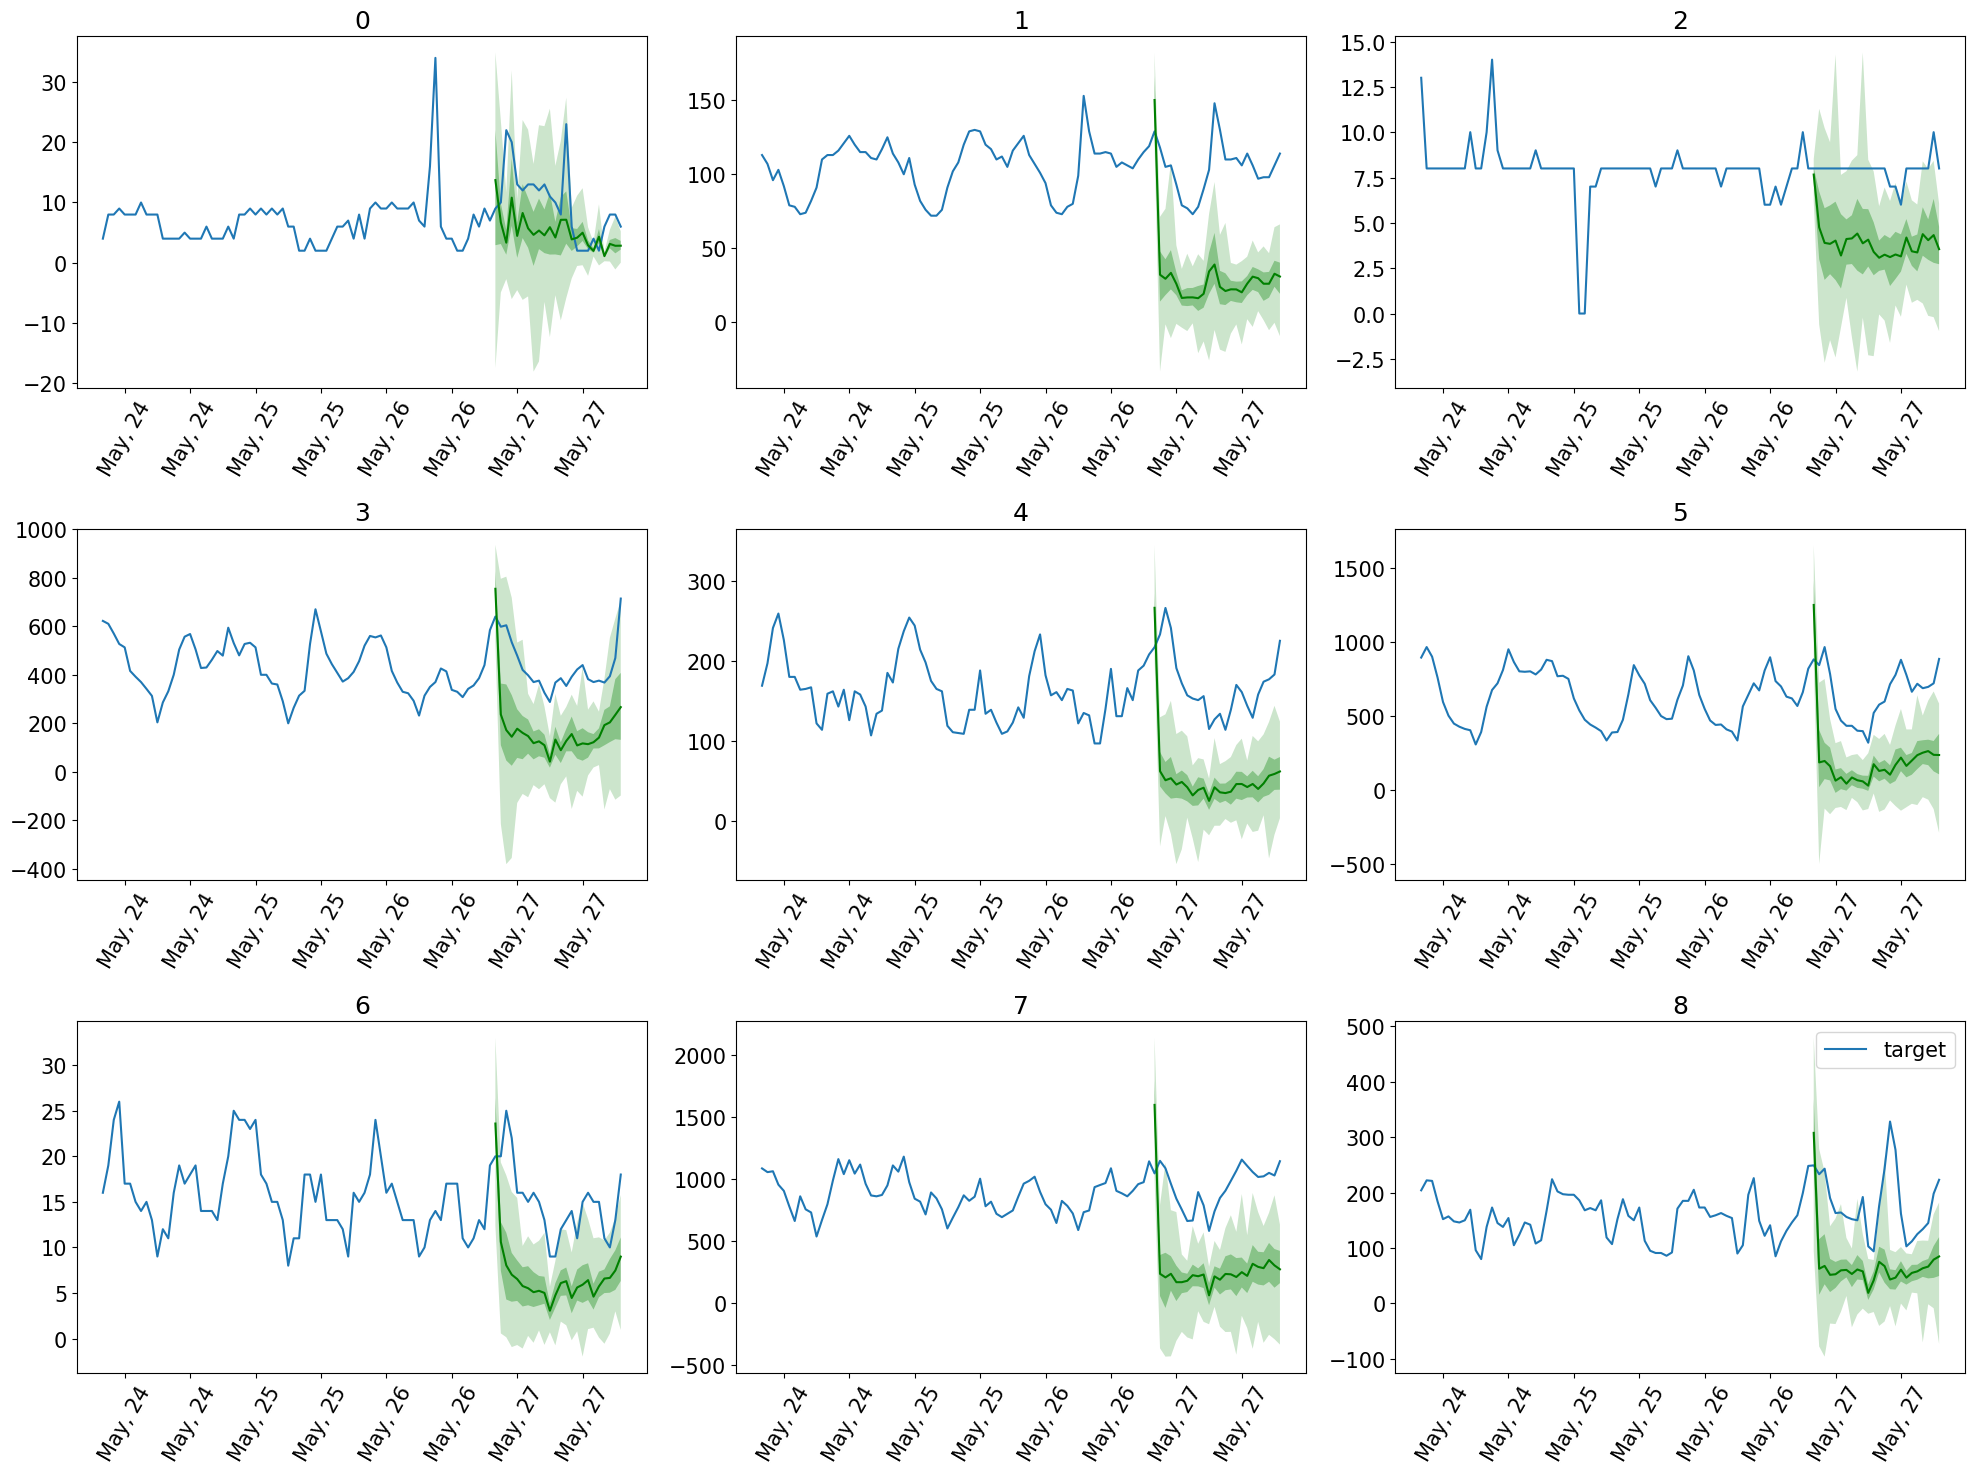

In [19]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    # Convert index for plot
    ts = ts[-4 * dataset.metadata.prediction_length:].to_timestamp()
    
    plt.plot(ts, label="target")
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    plt.title(forecast.item_id)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()

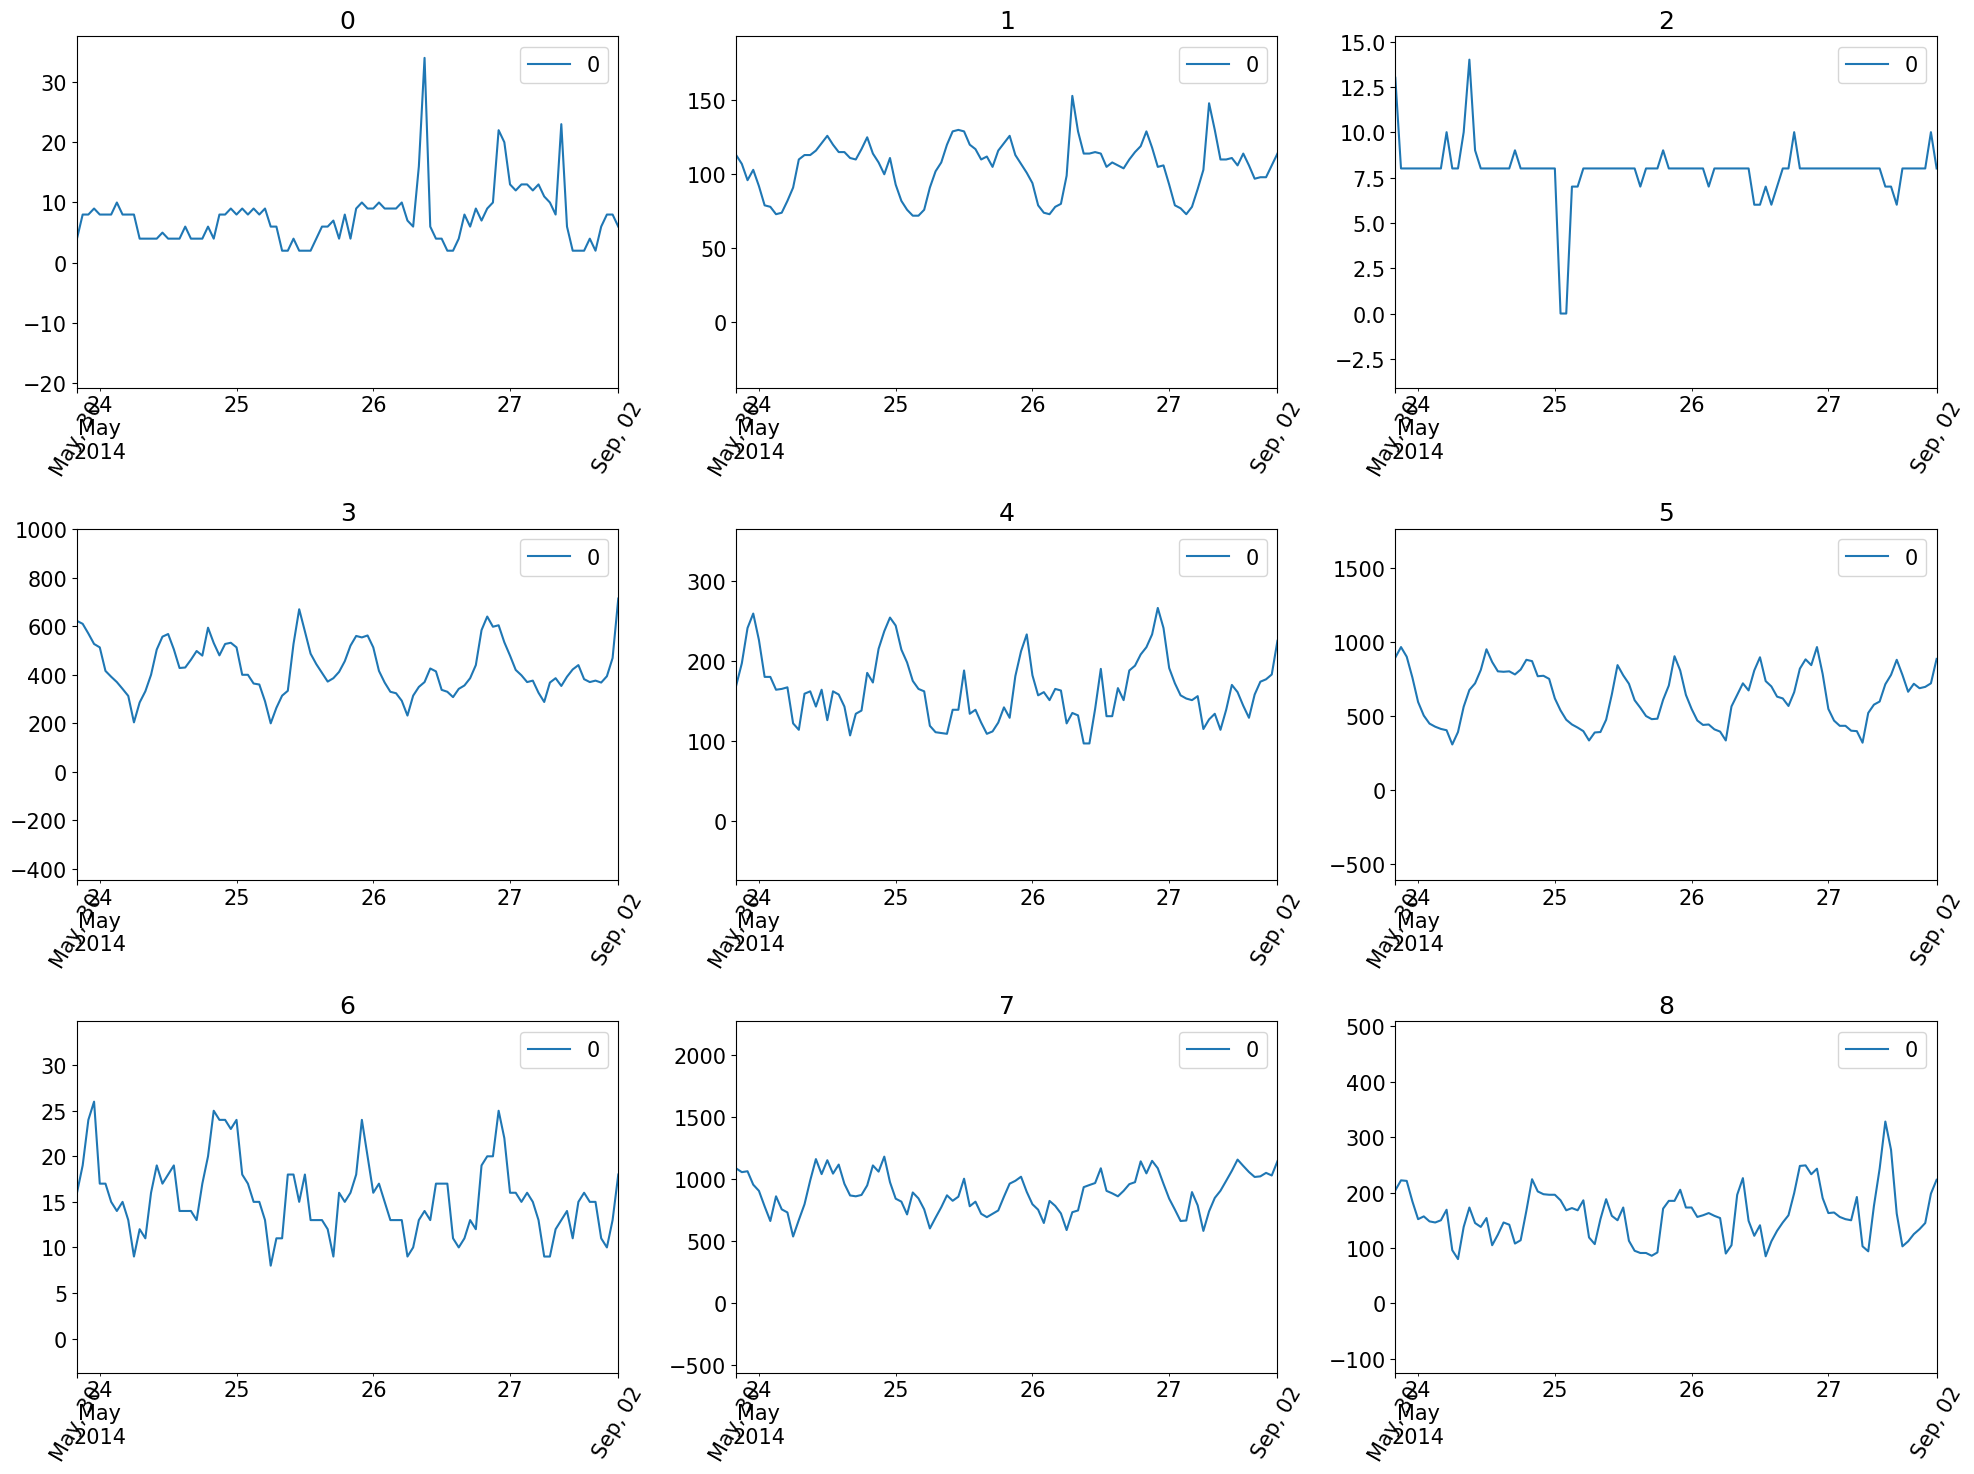

In [18]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    ts[-4 * dataset.metadata.prediction_length:].plot(ax=ax, label="target",)
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    plt.title(forecast.item_id)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()